# Implementation of GRAD CAM :

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1

!pip install -q keras-cv tensorflow
!pip install -q keras-cv tensorflow
!pip install -q keras

import numpy as np
import tensorflow as tf
import keras_cv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from tensorflow.keras import layers as tfkl
from tensorflow import keras as tfk
import json
import urllib.request
from tensorflow.keras import Model

# Function to compute Grad-CAM
def grad_cam(model, img_tensor, class_idx, layer_name="conv_1"):
    """
    Compute the Grad-CAM heatmap for the given image and class.
    """
    # Create a model that gives us the gradient of the last convolutional layer w.r.t the output
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Watch the input tensor
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]  # Use the class of interest

    # Compute the gradient of the loss w.r.t. the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)

    # Global Average Pooling of the gradients (weights)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the corresponding weight and sum them up
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.squeeze(heatmap)  # Remove extra dimensions

    # Normalize the heatmap to a range of 0 to 1
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Function to overlay the Grad-CAM heatmap on the image
def display_grad_cam(heatmap, image, alpha=0.4):
    """
    Superimpose the Grad-CAM heatmap on the image.
    """
    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to a color image (jet colormap)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Ensure the original image is in uint8 format
    image_uint8 = np.uint8(image * 255) if image.max() <= 1 else np.uint8(image)

    # Superimpose the heatmap on the image
    img_with_heatmap = cv2.addWeighted(image_uint8, 1 - alpha, heatmap_colored, alpha, 0)

    return img_with_heatmap

# Define classical augmentations (rotation, flip, zoom, etc.)
def apply_classical_augmentation(image):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)

    # Random rotation between -20 and 20 degrees (converted to radians)
    image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))  # Random 90 degree rotations

    # Random zoom (scaling)
    image = tf.image.resize(image, [int(image.shape[0] * tf.random.uniform([], minval=0.8, maxval=1.2)),
                                    int(image.shape[1] * tf.random.uniform([], minval=0.8, maxval=1.2))])
    image = tf.image.resize(image, [299, 299])  # Resize back to target size

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    return image

# Define preprocessing step
def preprocess(image, label):
    # Apply classical augmentation before preprocessing
    # image = apply_classical_augmentation(image)

    # Convert image to float32
    image = tf.cast(image, tf.float32)

    # Get image dimensions
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Determine crop size (smallest dimension)
    crop_size = tf.minimum(height, width)

    # Calculate offsets for center cropping
    height_offset = (height - crop_size) // 2
    width_offset = (width - crop_size) // 2

    # Center-crop and resize image to 299x299
    image = tf.image.crop_to_bounding_box(
        image,
        height_offset,
        width_offset,
        crop_size,
        crop_size
    )
    image = tf.image.resize(image, [299, 299])

    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image, label

# Function to prepare data by applying preprocessing and augmentations
def prepare_data(X_data, y_data):
    # Define image shape after preprocessing
    img_shape = (299, 299, 3)

    # Initialize arrays to store processed data
    X_processed = np.zeros((len(X_data), *img_shape), dtype=np.float32)
    y_processed = np.array(y_data, dtype=np.int64)

    # Batch-process and store data
    batch_size = 32
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    dataset = dataset.map(preprocess).batch(batch_size)

    idx = 0
    for batch_images, batch_labels in dataset:
        batch_size = batch_images.shape[0]
        X_processed[idx:idx + batch_size] = batch_images.numpy()
        y_processed[idx:idx + batch_size] = batch_labels.numpy()
        idx += batch_size

        # Optional: print progress for processing data
        if idx % 500 == 0:
            print(f"Processed {idx}/{len(X_data)} images")

    return X_processed, y_processed

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 58.8 MB/s eta 0:00:00


In [ ]:
# Generate the filename
model_filename = f'DEMO.keras'

# Transfer learning :
- Transfer learning is the process of using a pre-trained model as a starting point for a new but related task, leveraging its learned features to reduce training time and improve performance.
- It allows reusing the knowledge from, let's say MobileNet (a quite complex and powerful model), trained on ImageNet (one the biggest image dataset), even though the classes are not the same and the images in ImageNet are not exactly similar images as our blood cell images.
- That's why we need a Dense layer to adapt the model to our 8 classes (ImageNet has a few hundreds classes).

In [ ]:
# Load our pre-saved data (cut in train/val sets) :
X_train_augmented = np.load("X_train_augmented_V2.npy")
y_train_balanced = np.load("y_train_balanced_V2.npy")
X_val = np.load("X_val_V2.npy")
y_val = np.load("y_val_V2.npy")
X_train_augmented = X_train_augmented * 255 # Ensures the right scaling of the augmented data
# (for augmentation purposes, the images were scaled between 0 and 1).

# Re-augmenting and preprocessing training data (the main augmentation - using AugMix - was already done!) :
X_train, y_train = prepare_data(X_train_augmented, y_train_balanced)
X_val, y_val = prepare_data(X_val, y_val)

# Display data shapes for training & validation sets :
print("Training set shape (images):", X_train.shape)
print("Training set shape (labels):", y_train.shape)
print("Validation set shape (images):", X_val.shape)
print("Validation set shape (labels):", y_val.shape)

# Convert class labels to categorical format for training & validation sets :
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

# Load the pre-trained MobileNetV3 model without the top (output) layer :
mobilenet = tfk.applications.MobileNetV3Large(
    input_shape=(299, 299, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)

# Freeze all layers in the base model for feature extraction :
mobilenet.trainable = False

# Add a dropout layer for regularisation :
x = tfkl.Dropout(0.3, name='dropout')(mobilenet.output)

# Add final Dense layer for classification with softmax activation :
x = tfkl.Dense(8, activation='softmax')(x) # 8 output classes in our problem !

# Define the complete model linking input and output :
model = Model(inputs=mobilenet.input, outputs=x)

# Compile the model with categorical cross-entropy loss and Lion optimiser :
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(), metrics=['accuracy'])

# Load ImageNet class labels :
class_idx_url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
with urllib.request.urlopen(class_idx_url) as response:
    class_idx = json.load(response)

# Train the model on our custom blood cell images cut into train/val sets :
model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Let's save the model obtained via transfer-learning for further use :
model.save(model_filename)
print(f"Model saved as {model_filename}") # The filename is the one you chose on top of this file.
del model

Processed 4000/15840 images
Processed 8000/15840 images
Processed 12000/15840 images
Training set shape (images): (15840, 299, 299, 3)
Training set shape (labels): (15840,)
Validation set shape (images): (1792, 299, 299, 3)
Validation set shape (labels): (1792,)


/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.6303 - loss: 1.0713 - val_accuracy: 0.9275 - val_loss: 0.2305
Epoch 2/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8244 - loss: 0.5627 - val_accuracy: 0.9347 - val_loss: 0.2035
Epoch 3/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8362 - loss: 0.5526 - val_accuracy: 0.9414 - val_loss: 0.1917
Epoch 4/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8438 - loss: 0.5434 - val_accuracy: 0.9297 - val_loss: 0.2378
Epoch 5/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8420 - loss: 0.5448 - val_accuracy: 0.9358 - val_loss: 0.2087
Epoch 6/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8414 - loss: 0.5443 - val_accuracy: 0.9342 - val_loss: 0.1992
Epoch 7/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8447 - loss: 0.5596 - val_accuracy: 0.9314 - val_loss: 0.2348
Epoch 8/50
495/495 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8451 - loss: 0.5637 - 

Here we show once again **GRAD CAM** on the transfer-learning model's predictions. This is done using our previously defined functions :
- grad_cam: to compute the Grad-CAM heatmap ;
- display_grad_cam: to overlay the Grad-CAM heatmap on the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


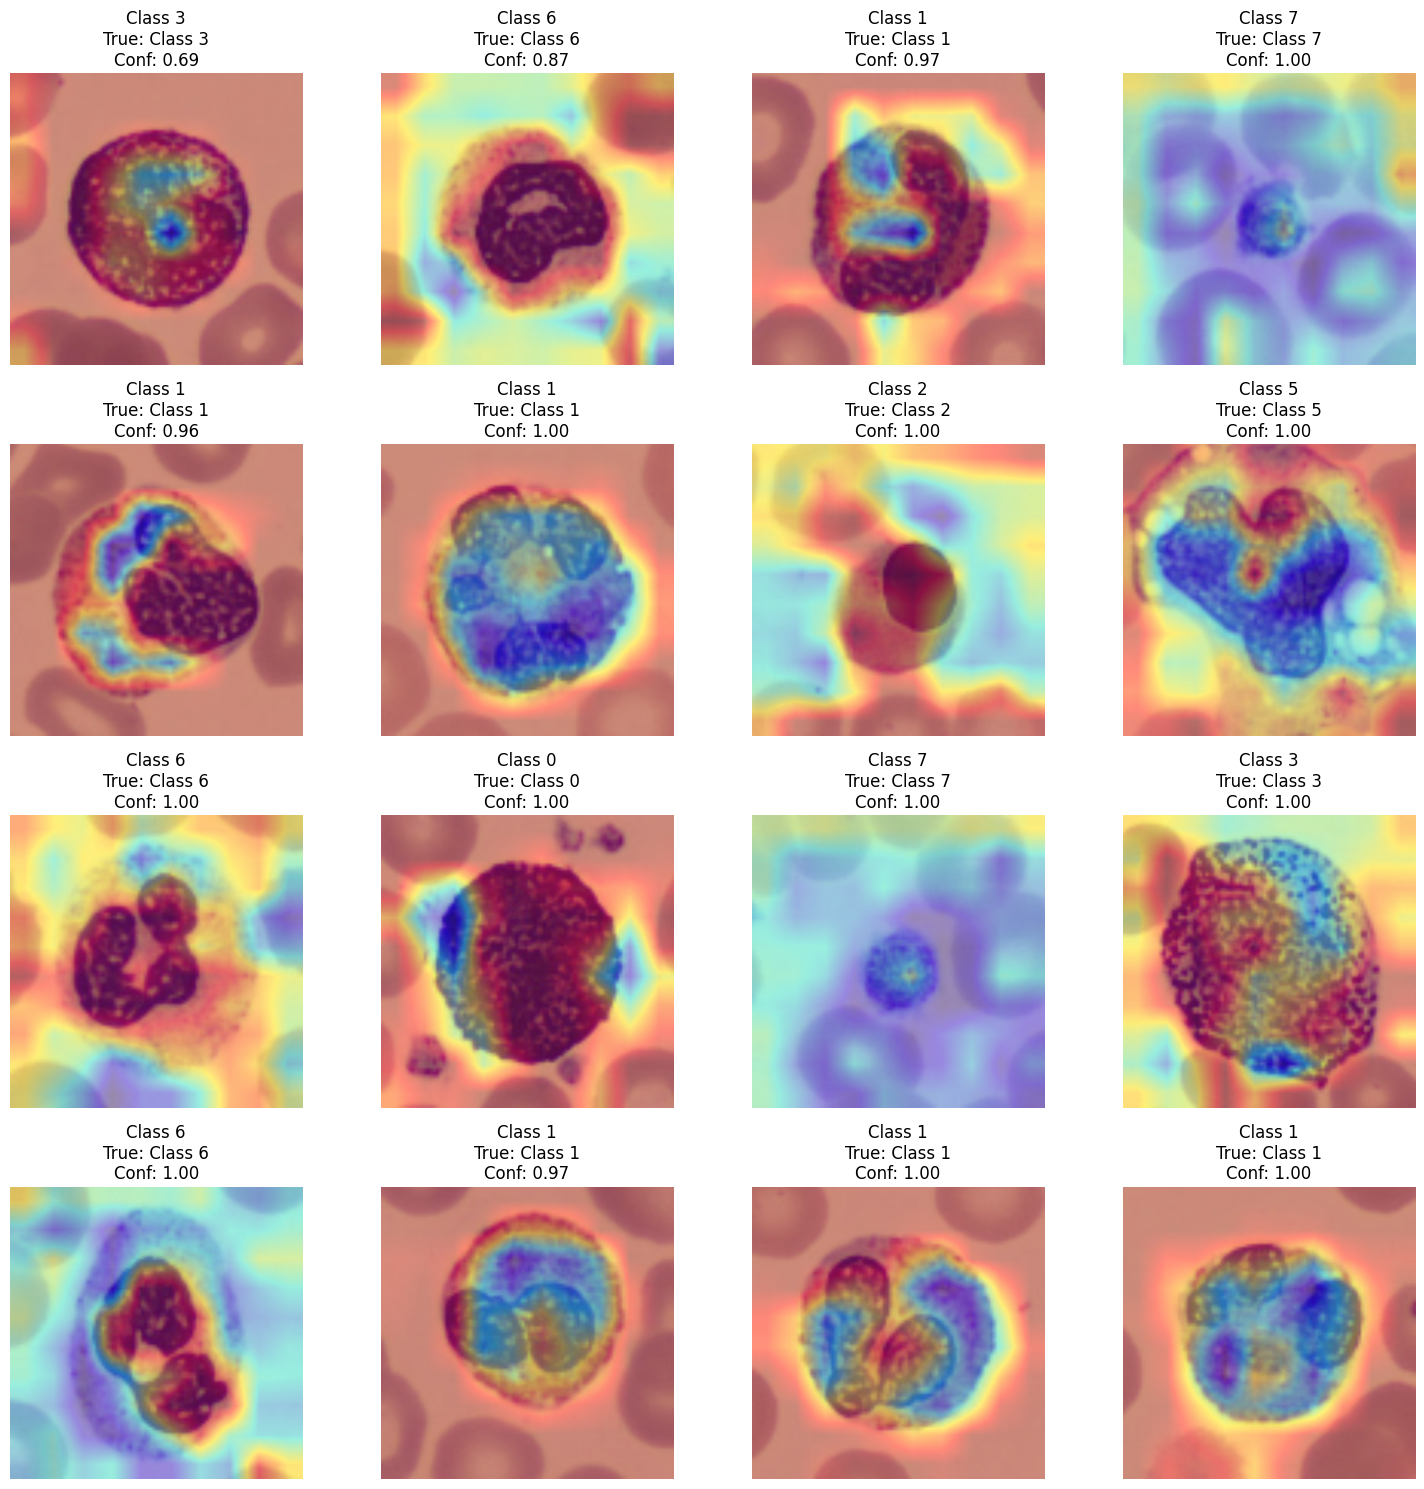

In [ ]:
import cv2

# Import model :
from tensorflow.keras.models import load_model
# Load the model
model = load_model(model_filename) # The filename is the one you chose on top of this file.

# Number of images to display
num_images = 16

# Create a plot grid for the images and Grad-CAMs
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i in range(num_images):
    img_index = i  # Index of the image from the validation set
    img = X_val[img_index]  # Get the image from validation set

    # Ensure the correct scaling of our image :
    img_preprocessed = img * 255

    # Convert the image to a tensor :
    img_tensor = tf.convert_to_tensor(np.expand_dims(img_preprocessed, axis=0), dtype=tf.float32)

    # Predict the class for the image :
    predictions = model.predict(img_tensor) # Contains the probabilities of the prediction.
    predicted_class_idx = np.argmax(predictions[0])  # Get the predicted class index.

    # Map the predicted class index to a label :
    predicted_class_label = f'Class {predicted_class_idx}'
    confidence = predictions[0][predicted_class_idx] # Gets the confidence score.

    # Get the true label from y_val :
    true_label = np.argmax(y_val[img_index])
    true_label_str = f'True: Class {true_label}'

    # Generate Grad-CAM heatmap :
    heatmap = grad_cam(model, img_tensor, predicted_class_idx, layer_name='conv_1')

    # Display the image with the Grad-CAM heatmap overlaid :
    ax = axes[i // 4, i % 4]  # Get the axes for the current plot
    img_with_heatmap = display_grad_cam(heatmap, img)

    # Plot the image with the overlayed heatmap :
    ax.imshow(img_with_heatmap)
    ax.axis('off')

    # Display the predicted and true labels, along with confidence :
    ax.set_title(f'{predicted_class_label}\n{true_label_str}\nConf: {confidence:.2f}')

plt.tight_layout() # To ensure the images don't overlap
plt.show()
del model

# Fine tuning :
- Here we use fine-tuning to improve the performance of the model on specialized data, i.e, our blood cell images (the pre-trained model was trained on imagenet, i.e, not on blood cells!).
- We do it by training some of its layers on blood cell images, *with a smaller learning rate to retain the knowledge from the original task*.

In [ ]:
# Import model :
from tensorflow.keras.models import load_model

ft_model = load_model(model_filename) # The filename is the one you chose on top of this file.

# Freeze all layers by default
for layer in ft_model.layers:
    layer.trainable = False

# Unfreeze specific layers by name or type : here we unfreeze all Conv2D layers :
for i, layer in enumerate(ft_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(f"Layer {i}: {layer.name}, Type: {type(layer).__name__}, Trainable: {layer.trainable}")

# In addition, we unfreeze the last 2/3 of the layers :
N = 124
for i, layer in enumerate(ft_model.layers[-N:]):
    layer.trainable = True

# Print the layer trainability status
print("\nLayer trainability status:")
for i, layer in enumerate(ft_model.layers):
    print(f"{i}: {layer.name}, Trainable: {layer.trainable}")

# Compile the model
ft_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),  # Small learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
ft_history = ft_model.fit(
    x=X_train * 255,  # Ensure correct input scaling
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model
ft_model.save(model_filename) # One again, the filename is the one you chose on top of this file.
del ft_model

Layer 2: conv, Type: Conv2D, Trainable: True
Layer 5: expanded_conv_depthwise, Type: DepthwiseConv2D, Trainable: True
Layer 8: expanded_conv_project, Type: Conv2D, Trainable: True
Layer 11: expanded_conv_1_expand, Type: Conv2D, Trainable: True
Layer 15: expanded_conv_1_depthwise, Type: DepthwiseConv2D, Trainable: True
Layer 18: expanded_conv_1_project, Type: Conv2D, Trainable: True
Layer 20: expanded_conv_2_expand, Type: Conv2D, Trainable: True
Layer 23: expanded_conv_2_depthwise, Type: DepthwiseConv2D, Trainable: True
Layer 26: expanded_conv_2_project, Type: Conv2D, Trainable: True
Layer 29: expanded_conv_3_expand, Type: Conv2D, Trainable: True
Layer 33: expanded_conv_3_depthwise, Type: DepthwiseConv2D, Trainable: True
Layer 37: expanded_conv_3_squeeze_excite_conv, Type: Conv2D, Trainable: True
Layer 39: expanded_conv_3_squeeze_excite_conv_1, Type: Conv2D, Trainable: True
Layer 42: expanded_conv_3_project, Type: Conv2D, Trainable: True
Layer 44: expanded_conv_4_expand, Type: Conv2D, T

Here we show once again **GRAD CAM** but this time on fine-tuned model's predictions. This is done using our previously defined functions :
- grad_cam: to compute the Grad-CAM heatmap ;
- display_grad_cam: to overlay the Grad-CAM heatmap on the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-1-cf9a4b635629>:49: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / np.max(heatmap)
<ipython-input-1-cf9a4b635629>:62: RuntimeWarning: invalid value encountered in cast
  heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


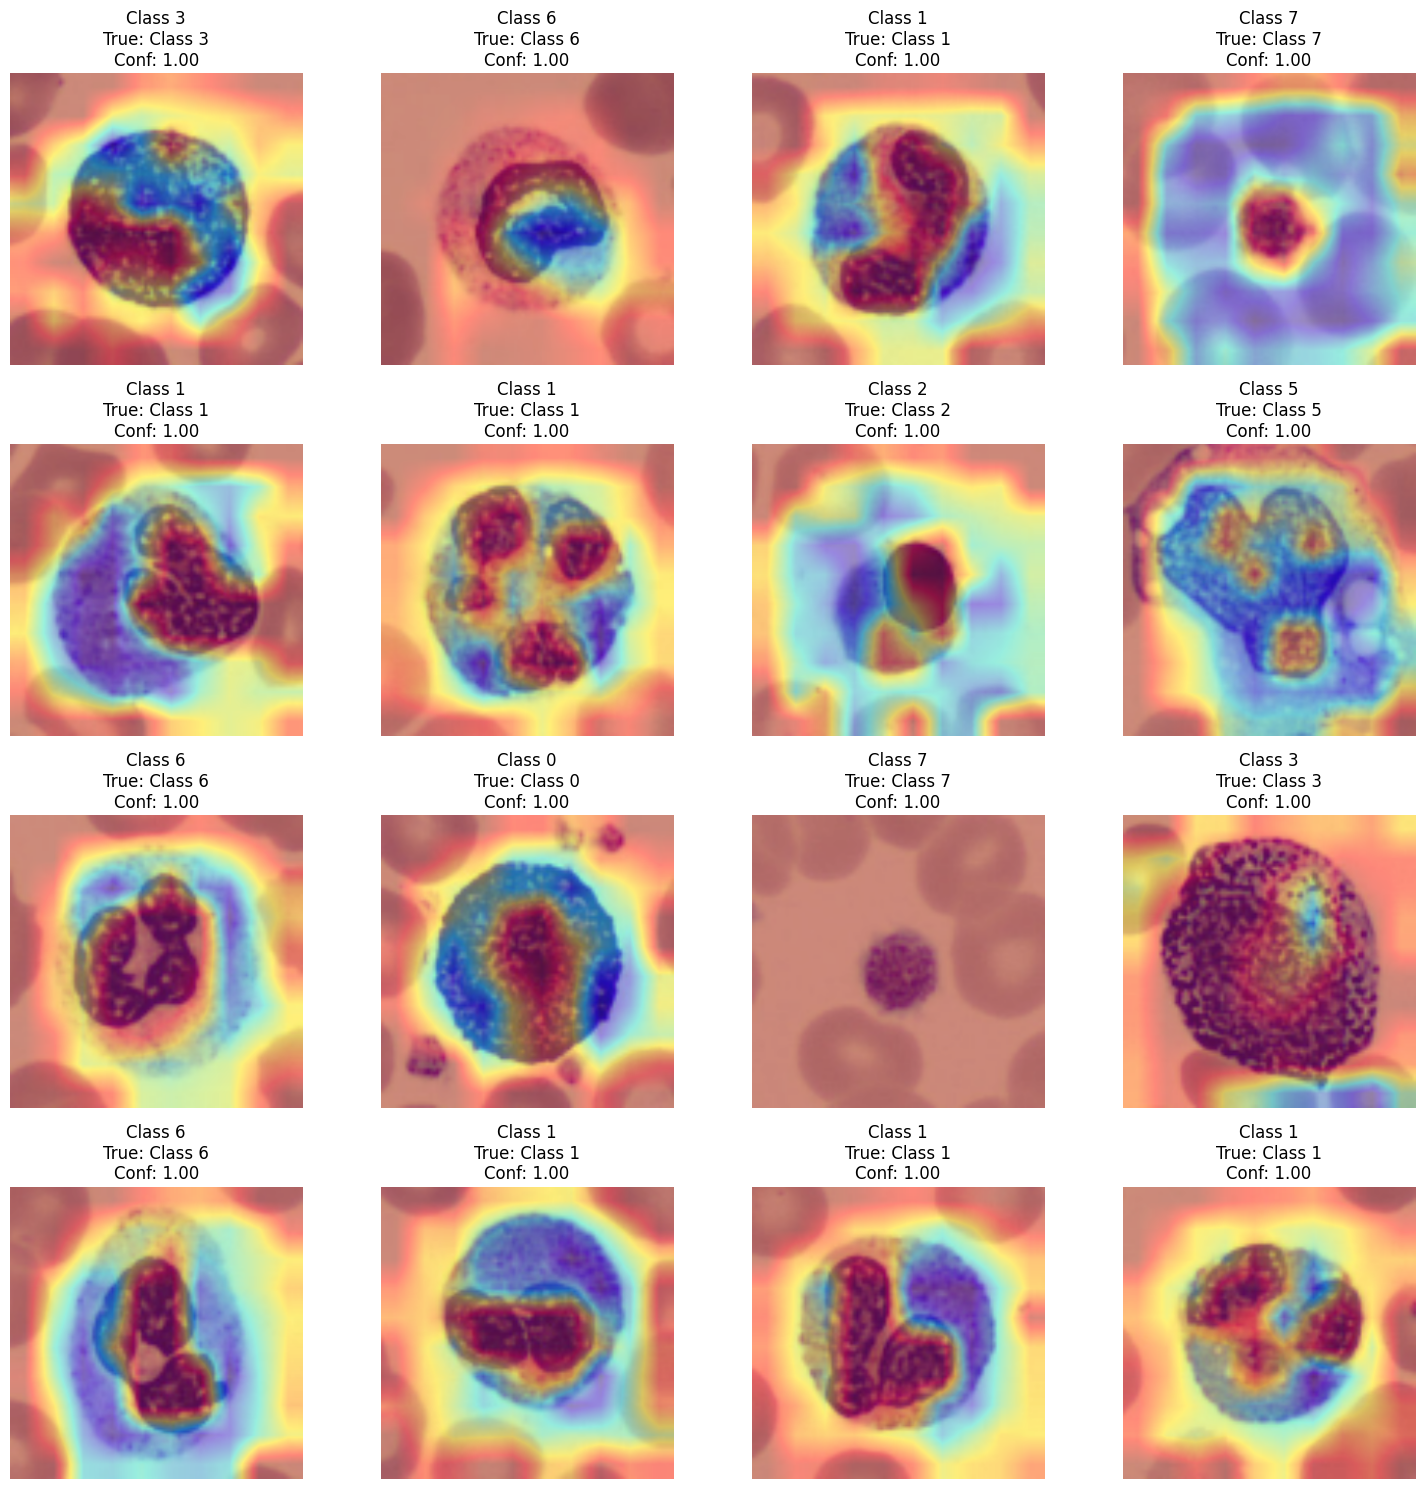

In [ ]:
# Import model :
from tensorflow.keras.models import load_model

model = load_model(model_filename) # The filename is the one you chose on top of this file.

# Number of images to display
num_images = 16

# Create a plot grid for the images and Grad-CAMs
fig, axes = plt.subplots(4, 4, figsize=(15, 15))


for i in range(num_images):
    img_index = i  # Index of the image from the validation set
    img = X_val[img_index]  # Get the image from validation set

    # Ensure correct input scaling :
    img_preprocessed = img * 255

    # Convert the image to a tensor :
    img_tensor = tf.convert_to_tensor(np.expand_dims(img_preprocessed, axis=0), dtype=tf.float32)

    # Predict the class for the image :
    predictions = model.predict(img_tensor) # Contains the probabilities.
    predicted_class_idx = np.argmax(predictions[0]) # Gets the predicted class index.

    # Map the predicted class index to a label :
    predicted_class_label = f'Class {predicted_class_idx}'
    confidence = predictions[0][predicted_class_idx] # Gets the confidence score.

    # Get the true label from y_val :
    true_label = np.argmax(y_val[img_index])
    true_label_str = f'True: Class {true_label}'

    # Generate Grad-CAM heatmap :
    heatmap = grad_cam(model, img_tensor, predicted_class_idx, layer_name='conv_1')

    # Display the image with the Grad-CAM heatmap overlaid :
    ax = axes[i // 4, i % 4]  # Get the axes for the current plot
    img_with_heatmap = display_grad_cam(heatmap, img)

    # Plot the image with the overlayed heatmap
    ax.imshow(img_with_heatmap)
    ax.axis('off')

    # Display the predicted and true labels, along with confidence in prediction :
    ax.set_title(f'{predicted_class_label}\n{true_label_str}\nConf: {confidence:.2f}')

plt.tight_layout()  # To ensure the images don't overlap
plt.show()
del model

# Focus on images where prediction went wrong :
- Our idea is that plotting Grad-CAM for misclassified images can help us identify which parts of the image the model focused on when making its prediction, revealing potential reasons for the error.

In [ ]:
# If you didn't execute the cells on top of this file :

X_val = np.load("X_val_V2.npy")
y_val = np.load("y_val_V2.npy")
X_val, y_val = prepare_data(X_val, y_val)

# Display data shapes for training & validation sets :
print("Validation set shape (images):", X_val.shape)
print("Validation set shape (labels):", y_val.shape)

# Convert class labels to categorical format for training & validation sets :
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

Validation set shape (images): (1792, 299, 299, 3)
Validation set shape (labels): (1792,)


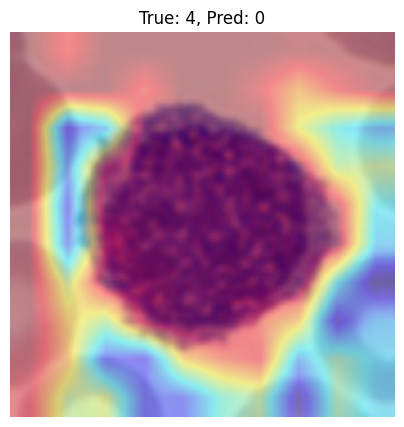

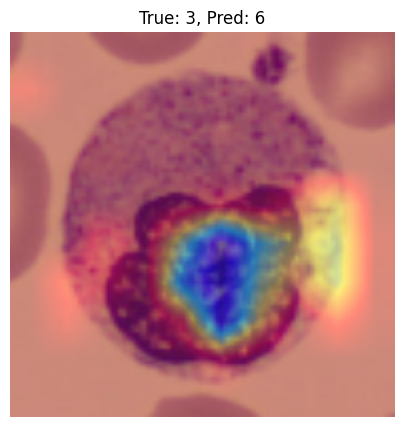

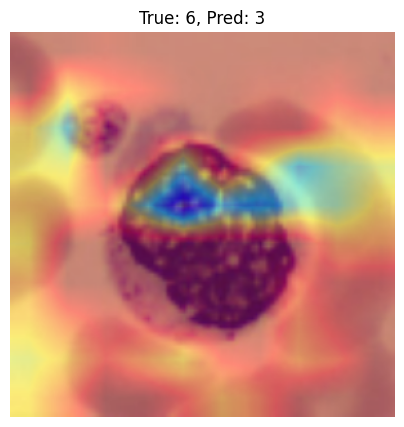

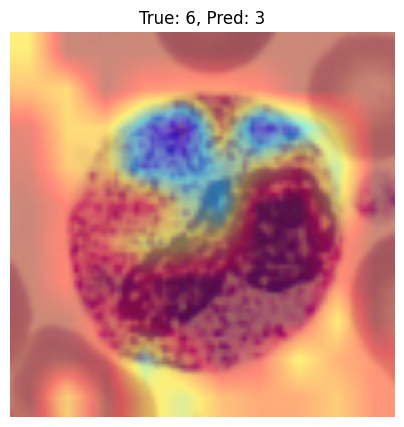

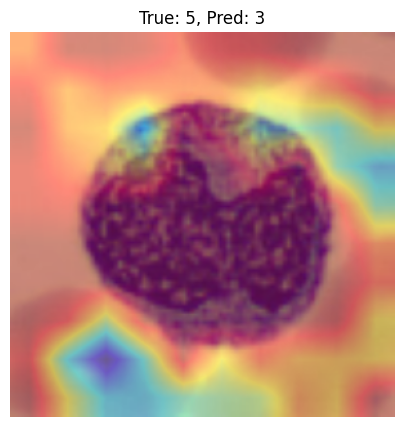

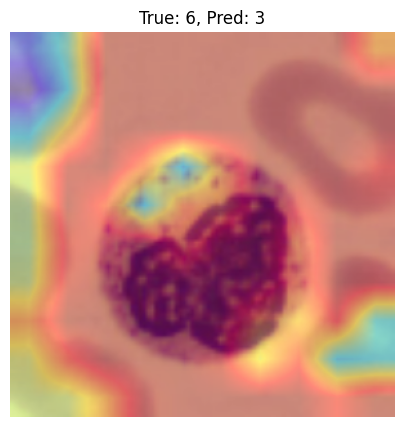

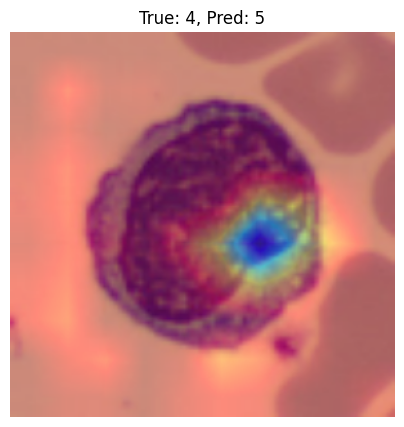

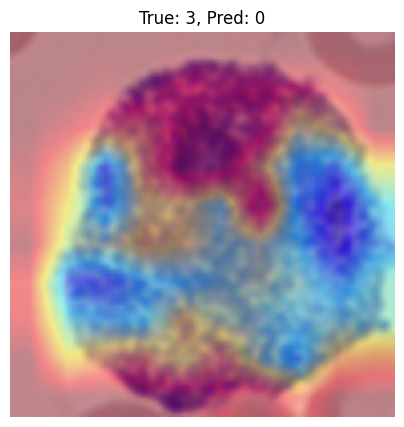

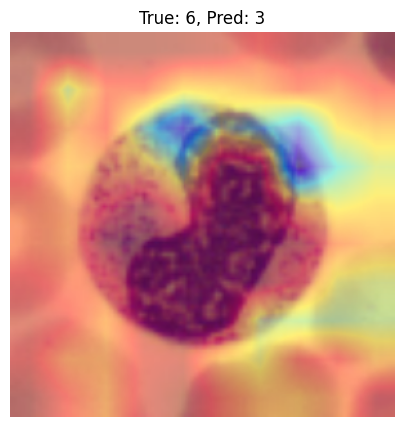

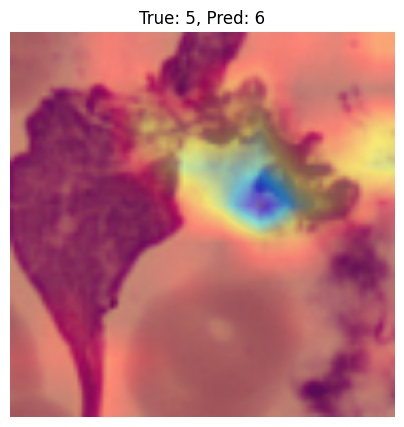

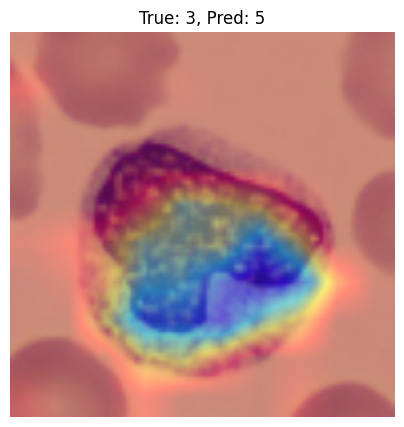

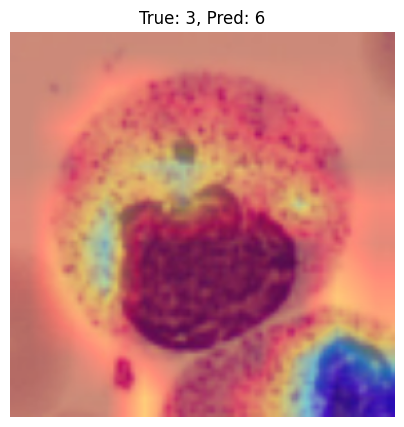

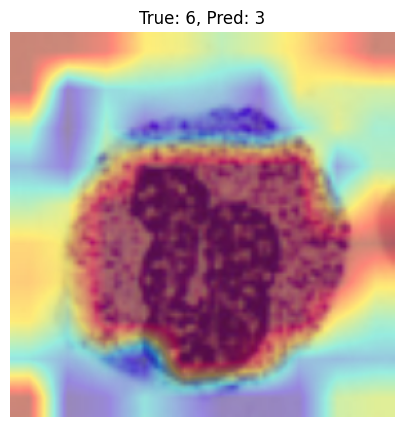

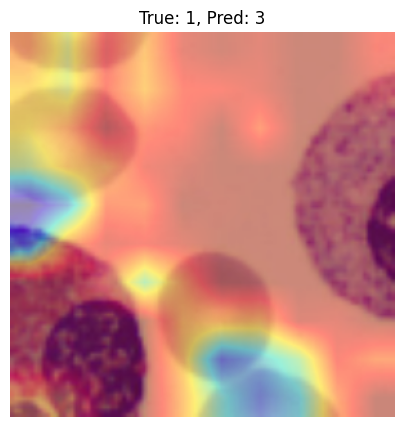

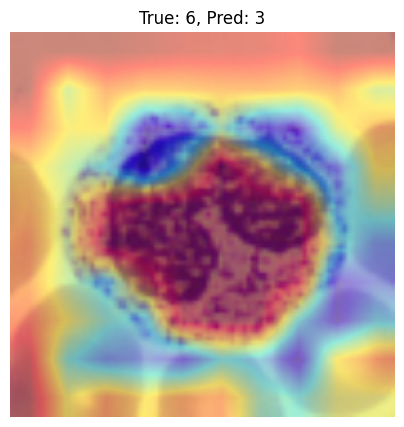

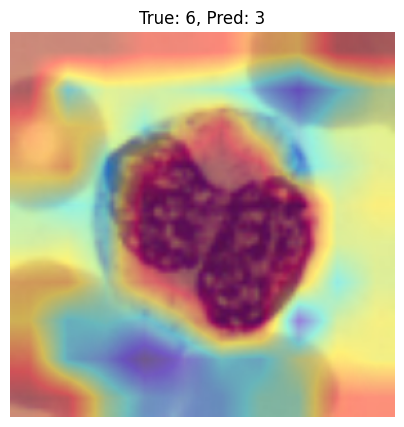

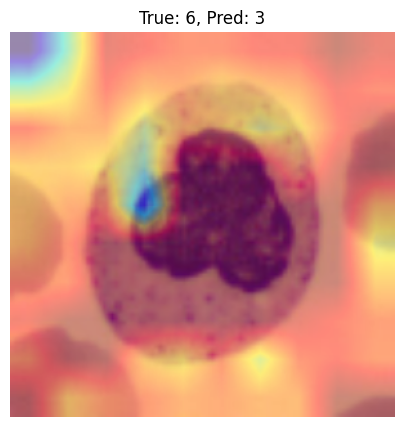

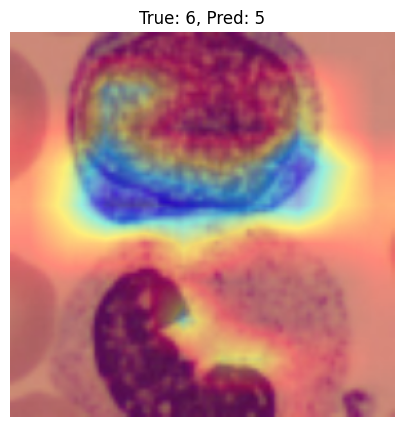

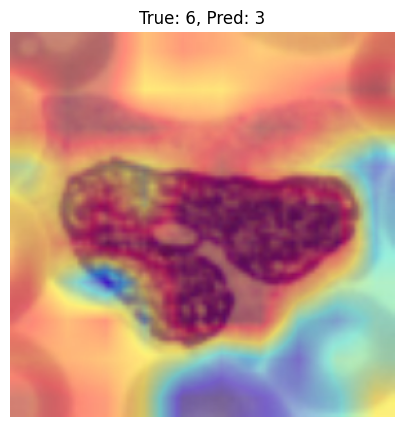

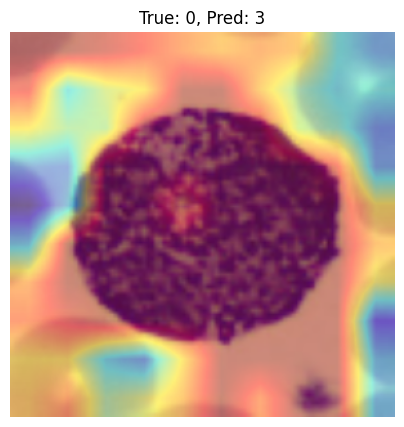

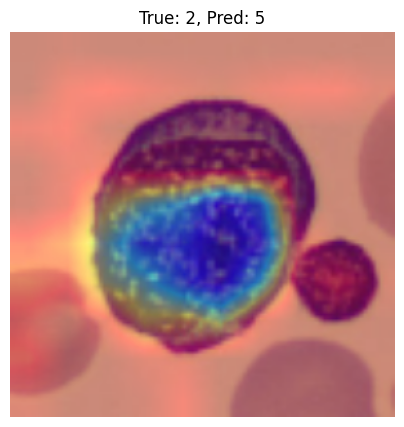

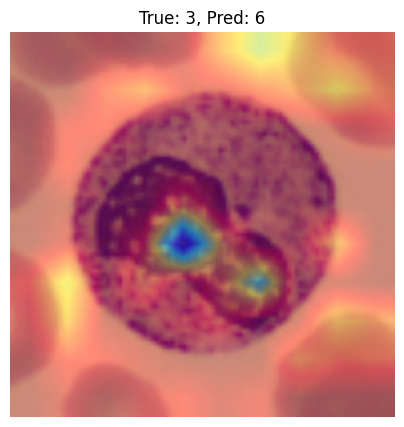

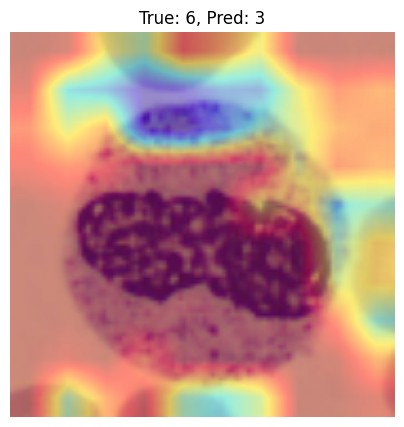

In [ ]:
import cv2
# Import model :
from tensorflow.keras.models import load_model

# Load the model
ft_model = load_model(model_filename)

# Find misclassified images
misclassified_images = []
misclassified_indices = []

# Loop through the validation set to find the misclassified images :
for i in range(len(X_val)):
    img = X_val[i]
    true_class_idx = np.argmax(y_val[i])

    img = img * 255
    img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)

    # Predict the class :
    predictions = ft_model.predict(img_tensor, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])

    # Check if the prediction is incorrect :
    if predicted_class_idx != true_class_idx:
        misclassified_images.append((img, true_class_idx, predicted_class_idx))
        misclassified_indices.append(i)

# Plot Grad-CAM for misclassified images :
for i, (img, true_class_idx, predicted_class_idx) in enumerate(misclassified_images):
    img_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)
    heatmap = grad_cam(ft_model, img_tensor, predicted_class_idx, layer_name='conv_1')
    img_with_heatmap = display_grad_cam(heatmap, img)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_with_heatmap)
    plt.title(f"True: {true_class_idx}, Pred: {predicted_class_idx}")
    plt.axis('off')
    plt.show()
